# LogReg ohne anpassungen

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, log_loss, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


In [14]:
df = pd.read_pickle('datenVorbUndersampling.pkl')

In [15]:
df

,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue,id,Geschlecht,Alter,Interesse
0,1,39.0,0,1,1,42012.0,26.0,128,262693,0,68,1.0
1,1,45.0,1,0,0,30592.0,152.0,268,106452,1,25,0.0
2,1,45.0,1,1,0,29234.0,124.0,72,196268,1,58,0.0
3,1,28.0,0,1,1,2630.0,26.0,197,313808,1,49,1.0
4,1,4.0,0,1,1,27368.0,124.0,89,257631,1,53,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
93415,1,29.0,1,1,0,36007.0,26.0,282,174856,0,51,0.0
93416,1,46.0,0,1,1,36342.0,26.0,24,103860,0,38,0.0
93417,1,27.0,0,0,1,2630.0,152.0,275,1918,1,29,0.0
93418,1,27.0,0,0,1,23971.0,152.0,194,350403,1,22,1.0


## Modell Training

In [44]:
X = df.drop('Interesse', axis=1)
y = df['Interesse']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
pipeline = Pipeline([('scaler',StandardScaler()),('logreg', LogisticRegression(solver='liblinear',penalty='l1',max_iter=100))]) #unterschiedliche scalen führen zu schlechter konvergenz ->viel itterationen
model = LogisticRegression(solver='liblinear',penalty='l1', max_iter= 100000) #l1 weil manche features keinen großen einfluss haben 
model.fit(X_train, y_train)
pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(penalty='l1', solver='liblinear'))])

## Cross Validation und Test 

In [45]:
scores = cross_val_score(pipeline, X_train, y_train, cv=5)

print(f'Trainingsatz Cossval: {scores}')
print(f'Druchschnitt:  {scores.mean()}')

Trainingsatz Cossval: [0.78064072 0.7795703  0.78882178 0.78431073 0.78674109]
Druchschnitt:  0.7840169239405446


In [51]:
y_pred = model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))
print(f"Train Accuracy: {model.score(X_train, y_train):.4f}")

Accuracy: 0.7904445871690573
              precision    recall  f1-score   support

         0.0       0.96      0.60      0.74     13902
         1.0       0.71      0.98      0.82     14124

    accuracy                           0.79     28026
   macro avg       0.84      0.79      0.78     28026
weighted avg       0.84      0.79      0.78     28026

Train Accuracy: 0.7841


In [47]:
y_pred = pipeline.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))
print(f"Train Accuracy: {pipeline.score(X_train, y_train):.4f}")

Accuracy: 0.7903732248626275
              precision    recall  f1-score   support

         0.0       0.96      0.60      0.74     13902
         1.0       0.71      0.98      0.82     14124

    accuracy                           0.79     28026
   macro avg       0.84      0.79      0.78     28026
weighted avg       0.84      0.79      0.78     28026

Train Accuracy: 0.7840


## Auswertungen

In [48]:
# Vorhersagewahrscheinlichkeiten für die Klasse 1 (positive Klasse)
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
# Log Loss
logloss = log_loss(y_test, y_pred_prob)

# AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_pred_prob)
print(f"Log Loss: {logloss:.4f}")
print(f"AUC: {auc:.4f}")


Log Loss: 0.4369
AUC: 0.8369


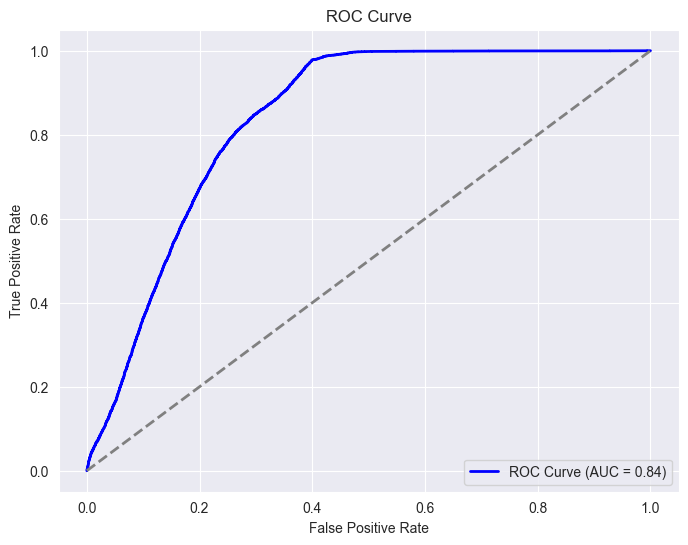

In [49]:

# Berechnung der FPR und TPR für verschiedene Schwellenwerte
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)


# Plotten der ROC-Kurve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonale Linie für zufällige Klassifikation
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Feature Einfluss

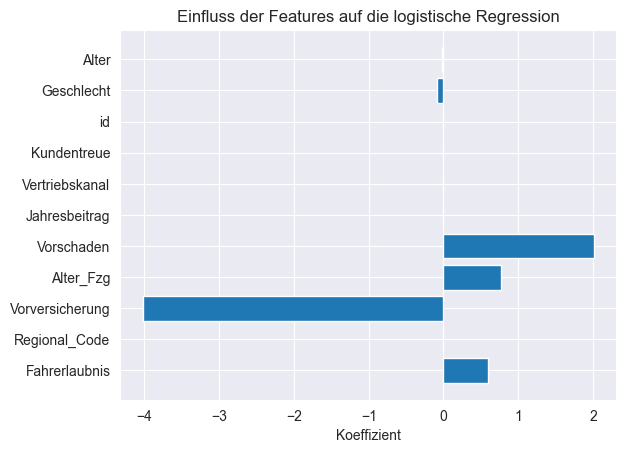

In [50]:
coefficients = model.coef_[0]
feature_names = X.columns
# Visualisierung
plt.barh(feature_names, coefficients)
plt.xlabel('Koeffizient')
plt.title('Einfluss der Features auf die logistische Regression')
plt.show()